In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2 as cv
from matplotlib.colors import ListedColormap

In [2]:
def unfolding(img):

    features = tuple(img.shape)
    img = img.reshape(-1,3)

    return img, features
    
def Normal(img,white_limit):

    data, features = unfolding(img)

    std = data.std(1)
    hist, bin_edges = np.histogram(std,bins = 50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    sorted_idx = np.argsort(hist)
    max_idx = sorted_idx[-1]
    
    mean_hist = bin_centers[max_idx]
    sigma = np.std(std)

    sigma_idx = np.where(std <= mean_hist + (0.5*sigma))
    sigma_filt = np.std(std[sigma_idx])
    stdlim = mean_hist + 3*sigma_filt

    idx_background = np.where(std <= stdlim)[0]
    background_reference = data[idx_background]
    background_reference_mean = background_reference.mean(1)
    white_idx = np.where(background_reference_mean >= white_limit)[0]
    white_reference =  background_reference[white_idx]
    mean = white_reference.mean(0)

    construction_data = np.copy(data)
    ref_white = np.copy(data)

    construction_data = construction_data/mean
    np.place(construction_data, construction_data > 1,1)

    ref_white[idx_background[white_idx]] = np.array([0,0,0])
    construction_data = np.reshape(construction_data,features)
    ref_white = np.reshape(ref_white,features)

    return construction_data, ref_white, mean

def RGB2Lab(img_data):

    e =  216/24389
  
    non_zero_rgb = img_data

    X = non_zero_rgb[:, 0] * 0.4124 + non_zero_rgb[:, 1] * 0.3576 + non_zero_rgb[:, 2] * 0.1805
    Y = non_zero_rgb[:, 0] * 0.2126 + non_zero_rgb[:, 1] * 0.7152 + non_zero_rgb[:, 2] * 0.0722
    Z = non_zero_rgb[:, 0] * 0.0193 + non_zero_rgb[:, 1] * 0.1192 + non_zero_rgb[:, 2] * 0.9505

    fx = (X/0.94811) 
    fy = (Y/1)
    fz = (Z/1.07304) 

    if fx.any() > e:
        fx = fx**(1/3)
    else:
        fx = ((903.3*fx)+16)/116

    if fy.any() > e:
        fy = fy**(1/3)
    else:
        fy = ((903.3*fy)+16)/116

    if fz.any() > e:
        fz = fz**(1/3)
    else:
        fz = ((903.3*fz)+16)/116

    a = (fx - fy) * 500
    b = (fy - fz) * 200
    L = (fy * 116) - 16
    
    data_CLab = np.column_stack((L, a, b))
    
    return data_CLab


def image_segmentation(img,k):

    img = np.array(img, dtype=np.float64)
    img,features = unfolding(img)

    kmeans= KMeans(n_clusters = k, init = "k-means++",random_state = 0, n_init = "auto")
    kmeans.fit(img)

    segmented_img = kmeans.labels_
    
    info = []
    Lab = []

    for i in range(0,k):

        idx  = np.where(segmented_img == i)
        mask = img[idx]
        info.append(mask.shape[0])

        if i > 0:
            Lab_mean = mask.mean(0)
            Lab.append(Lab_mean)
        

    info = np.array(info[1:])
    pix_sample = np.sum(info)
    info = (info/pix_sample)*100

    Lab = np.array(Lab)

    segmented_img = np.reshape(segmented_img,features[:-1])
    return segmented_img,info,Lab

def mask_segmentation(img,Labimg,masks,n_mask,k):

    rgb = np.copy(img)
    Lab = np.copy(Labimg)

    info = []

    for i in range(1,k+1):

        idx  = np.where(masks == i)
        mask = img[idx]
        info.append(mask.shape[0])
    
    pix_sample = np.sum(info)
    info = (info/pix_sample)*100


    mask = np.stack((masks,masks,masks),axis = 2)
    np.place(Lab,mask == 0,0)
    np.place(rgb,mask == 0,1)
    
    if n_mask == 1:

        idx = np.where(masks == 1)
        total_pixel = Lab[idx].shape
        total = info[0]

        np.place(Lab,np.logical_or(mask == 2, mask == 3), 0)
        np.place(rgb,np.logical_or(mask == 2, mask == 3), 1)


    elif n_mask == 2:

        idx = np.where(masks == 2)
        total_pixel = Lab[idx].shape
        total = info[1]

        np.place(Lab,np.logical_or(mask == 1, mask == 3), 0)
        np.place(rgb,np.logical_or(mask == 1, mask == 3), 1)

    elif n_mask == 3: 

        idx = np.where(masks == 3)
        total_pixel = Lab[idx].shape
        total = info[2]
        
        np.place(Lab,np.logical_or(mask == 1, mask == 2), 0)
        np.place(rgb,np.logical_or(mask == 1, mask == 2), 1)

    masks_, info_,Lab_ = image_segmentation(Lab,k)
    
    info_ = (total*info_)/100
  

    return rgb,masks_,info_,Lab_     

Porcentaje de la muestra: [34.91803095 52.39580301 12.68616604]
Lab promedio Sample_1: [78.61635377 -5.40492603  6.64208053]
Lab promedio Sample_2: [89.54482142 -5.76274845  6.60993413]
Lab promedio Sample_3: [64.30847105 -2.15423776  3.9670892 ]


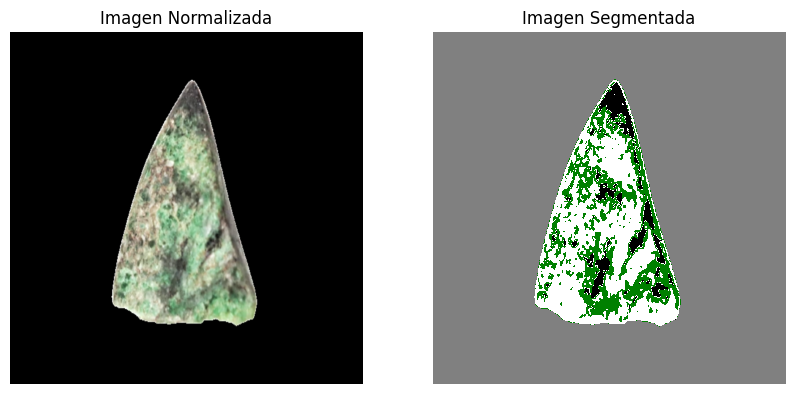

In [28]:
#if __name__ == "__main__":

img = cv.cvtColor(cv.imread("imgs/cara_a__3_-removebg-preview.png"),cv.COLOR_BGR2RGB)
img = cv.resize(img,(1000,1000))
img, ref, mean = Normal(img,white_limit=180)
imgLab = RGB2Lab(img.reshape(-1,3)).reshape(1000,1000,3)

masks, info,Lab = image_segmentation(imgLab,4)

print("Porcentaje de la muestra: " + str(info))

for i in range(0,len(Lab)):

    print("Lab promedio Sample_"+str(i+1)+": " + str(Lab[i]))

cmap = ListedColormap(["gray"]+["green"]+["white"]+["black"])
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Imagen Normalizada")
plt.axis("off")


plt.subplot(1,2,2)
plt.imshow(masks,cmap = cmap)
plt.title("Imagen Segmentada")
plt.axis("off")

plt.show()


Porcentaje de la muestra: [10.08098126  2.60518478]
Lab promedio Sample_1: [67.12196363 -2.50392808  4.41791618]
Lab promedio Sample_2: [53.99484106 -0.83009012  2.27306448]


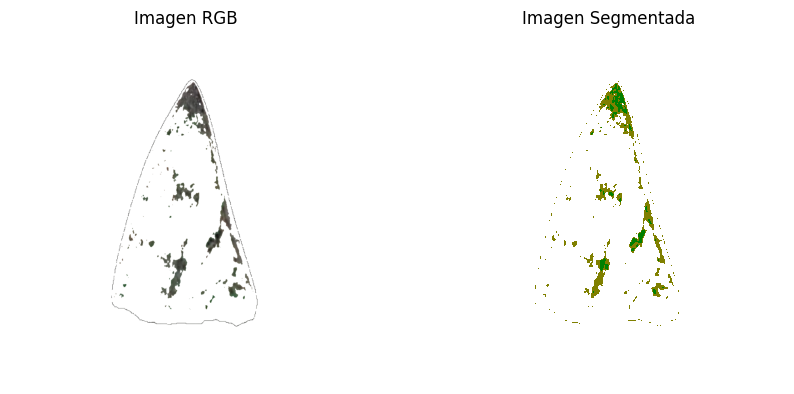

In [4]:
rgb, masks_, info_,Lab_ =  mask_segmentation(img,imgLab,masks,3,3)

print("Porcentaje de la muestra: "+ str(info_))

for i in range(0,len(Lab_)):

    print("Lab promedio Sample_"+str(i+1)+": " + str(Lab_[i]))

cmap = ListedColormap(["white", "olive", "green"])
plt.figure(figsize=(10,5))

plt.subplot(1,2,2)
plt.imshow(masks_,cmap = cmap)
plt.title("Imagen Segmentada")
plt.axis("off")

plt.subplot(1,2,1)
plt.imshow(rgb)
plt.title("Imagen RGB")
plt.axis("off")

plt.show()

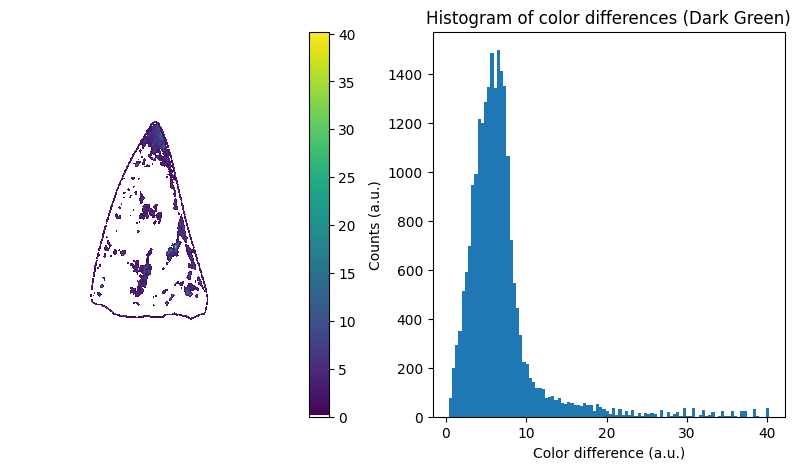

In [41]:
mask_selector = 3

mask2d = masks.reshape(-1)
img2d = img.reshape(-1,3)
idx = np.where(mask2d == mask_selector)
sample = img2d[idx]

lab_sample = RGB2Lab(sample)
ref_diff = lab_sample.mean(0)

diff_color = (((lab_sample[:,0]-ref_diff[0])**(2)) + ((lab_sample[:,1]-ref_diff[1])**(2)) + ((lab_sample[:,2]-ref_diff[2])**(2)))**(1/2)


map_color = np.zeros((1000,1000))
map_color2d = map_color.reshape(-1)
map_color2d[idx] = diff_color

cmap = ListedColormap(["White"]+[plt.cm.viridis(i) for i in range(1,256)])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(map_color2d.reshape(1000,1000),cmap = cmap)
plt.colorbar()
plt.axis("off")


plt.subplot(1,2,2)


plt.hist(diff_color,bins = 100)

if mask_selector == 1:  
    plt.title("Histogram of color differences (Green)")
elif mask_selector == 2: 
    plt.title("Histogram of color differences (Light green)")
else: 
    plt.title("Histogram of color differences (Dark Green)")
plt.xlabel("Color difference (a.u.)")
plt.ylabel("Counts (a.u.)")
plt.show()


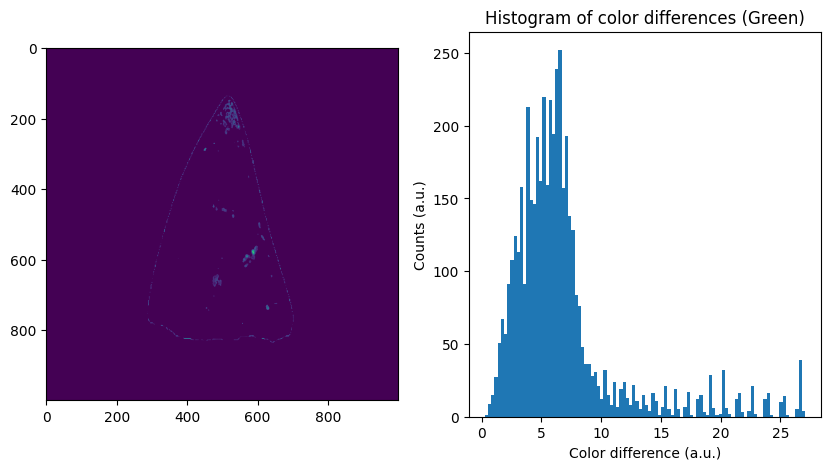

In [26]:
mask_selector = 2

mask2d = masks_.reshape(-1)
img2d = img.reshape(-1,3)
idx = np.where(mask2d == mask_selector)
sample = img2d[idx]

lab_sample = RGB2Lab(sample)
ref_diff = lab_sample.mean(0)

diff_color = (((lab_sample[:,0]-ref_diff[0])**(2)) + ((lab_sample[:,1]-ref_diff[1])**(2)) + ((lab_sample[:,2]-ref_diff[2])**(2)))**(1/2)


map_color = np.zeros((1000,1000))
map_color2d = map_color.reshape(-1)
map_color2d[idx] = diff_color

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(map_color2d.reshape(1000,1000),cmap = "viridis")


plt.subplot(1,2,2)


plt.hist(diff_color,bins = 100)

if mask_selector == 1:  
    plt.title("Histogram of color differences (Light green)")
elif mask_selector == 2: 
    plt.title("Histogram of color differences (Green)")
else: 
    plt.title("Histogram of color differences (Dark Green)")
    
plt.xlabel("Color difference (a.u.)")
plt.ylabel("Counts (a.u.)")
plt.show()
